In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import tensorflow as tf
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [50]:
data = pd.read_csv('SMSSpamCollection', sep = '\t', header = None)
data.columns = ['Label', 'Message']
data.head(10)

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [51]:
print(data.shape)

(5572, 2)


In [52]:
def get_wordnet_pos(tag):
  if tag.startswith('J'):
    return 'a'
  elif tag.startswith('V'):
    return 'v'
  elif tag.startswith('N'):
    return 'n'
  elif tag.startswith('R'):
    return 'r'
  else:
    return 'n'

english_vocab = set(w.lower() for w in nltk.corpus.words.words())

data_np = data.to_numpy()
data_normalized = []
stop_words = set(nltk.corpus.stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()
all_words = []
i = 0
for row in data_np:
  target = row[0]
  message = row[1]
  message_lower = message.lower()
  message_lower = re.sub(r'\W', ' ', message_lower)
  message_lower = re.sub(r'\s+', ' ', message_lower)
  words = nltk.word_tokenize(message_lower)
  message_pos_tokens = nltk.pos_tag(words)
  words_without_stopwords = []
  for word, tag in message_pos_tokens:
    if(word not in stop_words and word in english_vocab):
      # TODO: Add some logic to fix spellings/accronyms etc
      word_lemmatized = lemmatizer.lemmatize(word, get_wordnet_pos(tag))
      words_without_stopwords.append(word_lemmatized)
      all_words.append(word_lemmatized)
  message_normzalized = " ".join(words_without_stopwords)
  data_normalized.append([target, message_normzalized])
words_set = set(all_words)
vocab_size = len(words_set)
print(vocab_size)

3608


In [53]:
# Deciding length of words to create features later
message_length_count = {}
spam_message_length_count = {}
for data in data_normalized:
  if(data[0] == 'spam'):
    spam_message = data[1]
    spam_message_words = spam_message.split()
    spam_word_count = len(spam_message_words)
    if(spam_word_count in spam_message_length_count):
      spam_message_length_count[spam_word_count] += 1
    else:
      spam_message_length_count[spam_word_count] = 1

  message = data[1]
  message_words = message.split()
  word_count = len(message_words)
  if(word_count in message_length_count):
    message_length_count[word_count] += 1
  else:
    message_length_count[word_count] = 1

# Find mode
message_length_mode = 0
message_length_highest_count = 0
for item in message_length_count:
  if(message_length_count[item] > message_length_highest_count):
    message_length_mode = item
    message_length_highest_count = message_length_count[item]
print(message_length_mode)
print(message_length_highest_count)

3
806


Text(0.5, 1.0, 'Message length and their counts')

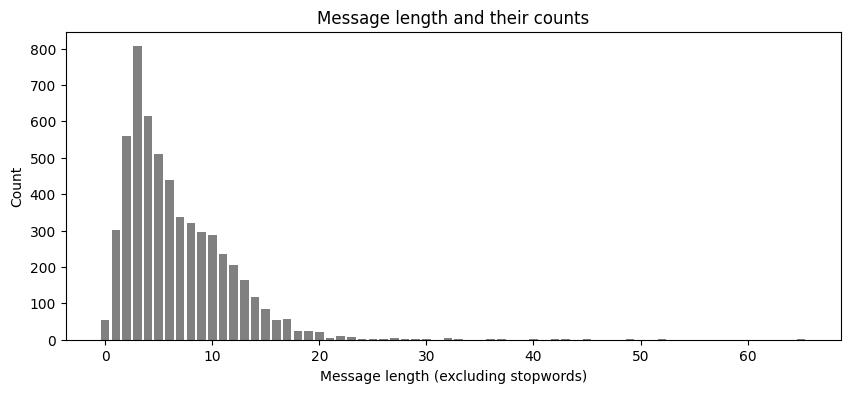

In [54]:
plt.figure(figsize = (10, 4))
plt.bar([item for item in message_length_count], [message_length_count[item] for item in message_length_count], color = 'grey')
plt.xlabel('Message length (excluding stopwords)')
plt.ylabel('Count')
plt.title('Message length and their counts')

Text(0.5, 1.0, 'Spam Message length and their counts')

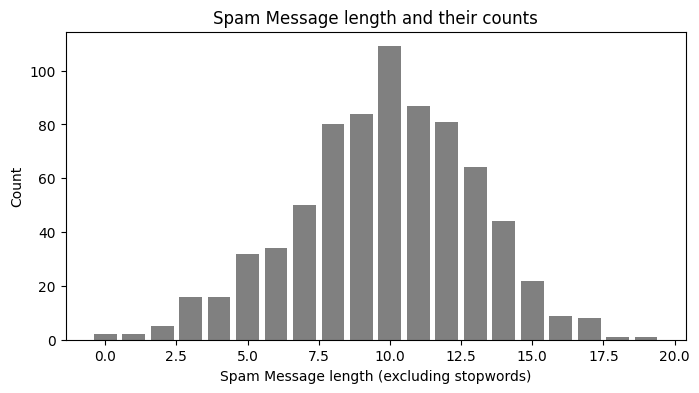

In [55]:
plt.figure(figsize = (8, 4))
plt.bar([item for item in spam_message_length_count], [spam_message_length_count[item] for item in spam_message_length_count], color = 'grey')
plt.xlabel('Spam Message length (excluding stopwords)')
plt.ylabel('Count')
plt.title('Spam Message length and their counts')

Looks like message length of 10 words is the most frequent among spam messages.

In [56]:
data_messages = [data[1] for data in data_normalized]
data_labels = [data[0] for data in data_normalized]
X_train, X_test, y_train, y_test = train_test_split(data_messages, data_labels, test_size = 0.3)

In [57]:
window_size = 3
context_size_half = int((window_size - 1) / 2)
embedding_size = 15

one_hot_map = {}
for i, word in enumerate(words_set):
  one_hot_map[word] = np.zeros(vocab_size)
  one_hot_map[word][i] = 1

def create_features(X, one_hot_map, context_size_half):
  features = []
  target = []

  for message in X:
    words = nltk.word_tokenize(message)
    for i in range(context_size_half, len(words) - context_size_half):
      target.append(one_hot_map[words[i]])
      feature = []
      for k in range(1, context_size_half + 1):
        feature.append(one_hot_map[words[i - k]])
        feature.append(one_hot_map[words[i + k]])
      features.append(feature)
  return features, target

features, target = create_features(X_train, one_hot_map, context_size_half)

def build_nn(features, target, hidden_units, vector_size):
  input1 = tf.keras.Input(shape = (vector_size,), name = 'input1')
  input2 = tf.keras.Input(shape = (vector_size,), name = 'input2')
  shared_embed = tf.keras.layers.Dense(hidden_units, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05), name = "embedded_layer")
  h1 = shared_embed(input1)
  h2 = shared_embed(input2)
  h = tf.keras.layers.Lambda(lambda z: (z[0] + z[1]) / 2.0)([h1, h2])
  output = tf.keras.layers.Dense(vector_size, activation='linear', name='output')(h)
  model = tf.keras.Model(inputs=[input1, input2], outputs=output)
  return model

model = build_nn(features, target, hidden_units=embedding_size, vector_size = vocab_size)
print(model.summary())

def train_nn(model, features, target):
  best_model_filepath = './best_model.keras'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = best_model_filepath,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    verbose = 1
  )

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])
  history = model.fit(features, target, epochs = 20, validation_split=0.1, callbacks = [model_checkpoint_callback])
  best_model = tf.keras.models.load_model(best_model_filepath, safe_mode=False)
  return best_model, history

feature1 = np.array([feature_i[0] for feature_i in features])
feature2 = np.array([feature_i[1] for feature_i in features])
target_np = np.array(target)
best_model, history = train_nn(model, [feature1, feature2], target_np)

best_model_weights = np.array(best_model.get_layer("embedded_layer").get_weights()[0])

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 3608)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 3608)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedded_layer      │ (None, 15)        │     54,135 │ input1[0][0],     │
│ (Dense)             │                   │            │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 15)        │          0 │ embedded_layer[0… │
│                     │                   │            │ embedded_layer[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 3608)      │     57,728 │ lambda_2[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 111,863 (436.96 KB)

 Trainable params: 111,863 (436.96 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
517/520 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0252 - loss: 8.9109
Epoch 1: val_loss improved from inf to 8.12994, saving model to ./best_model.keras
520/520 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.0253 - loss: 8.9078 - val_accuracy: 0.0346 - val_loss: 8.1299
Epoch 2/20
513/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0371 - loss: 8.0723
Epoch 2: val_loss improved from 8.12994 to 7.96181, saving model to ./best_model.keras
520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0371 - loss: 8.0715 - val_accuracy: 0.0346 - val_loss: 7.9618
Epoch 3/20
518/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0381 - loss: 7.8709
Epoch 3: val_loss improved from 7.96181 to 7.78489, saving model to ./best_model.keras
520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0381 - loss: 7.8706 - val_accuracy: 0.0346 - val_loss: 7.7849
Epoch 4/20
518/520 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0371 - loss: 7.6535
Epoch 4: val_loss improved from 7.78489 to

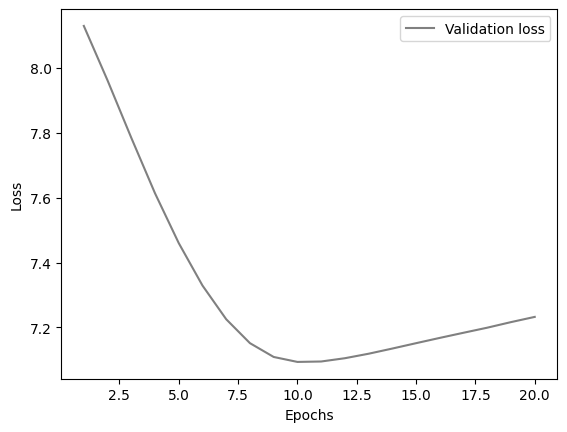

In [58]:
# Plotting validation loss over the epochs
val_loss = history.history['val_loss']
epochs = range(1, len(val_loss) + 1)
plt.plot(epochs, val_loss, color = 'grey', label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [59]:
# Get word embeddings from weights
def get_word_embeddings(one_hot_map, best_model_weights):
  word_embeddings = {}
  for word in one_hot_map:
    one_hot_word = one_hot_map[word]
    embedded_word = np.dot(best_model_weights.T, one_hot_word)
    word_embeddings[word] = embedded_word
  return word_embeddings

word_embeddings = get_word_embeddings(one_hot_map, best_model_weights)

In [60]:
def get_classifier_features_and_labels(X, y):
  feature_words = []
  target_labels = []
  for i in range(len(X)):
    message = X[i]
    target_labels.append(y[i])
    words = message.split()
    message_length = len(words)
    words_needed = []
    if(message_length >= 10):
      words_needed = words[:10]
    else:
      words_needed = words
      remaining_words = 10 - len(words)
      for j in range(remaining_words):
        words_needed.append('')
    feature_words.append(words_needed)
  return feature_words, target_labels

feature_words, target_labels = get_classifier_features_and_labels(X_train, y_train)
print(feature_words)
print(target_labels)

[['u', 'baby', 'girl', 'hope', 'u', 'every', 'time', 'call', 'ure', 'phone'], ['hey', 'check', 'da', 'list', 'da', '', '', '', '', ''], ['ur', 'cash', 'balance', 'currently', 'maximize', 'ur', 'cash', 'send', 'go', 'meg'], ['yesterday', '', '', '', '', '', '', '', '', ''], ['r', 'poor', 'india', 'poor', 'country', 'one', 'swiss', 'bank', 'lac', 'crore'], ['true', 'easier', '', '', '', '', '', '', '', ''], ['guess', 'get', '', '', '', '', '', '', '', ''], ['', '', '', '', '', '', '', '', '', ''], ['eh', 'den', 'sit', 'u', 'book', 'e', 'huh', '', '', ''], ['one', '', '', '', '', '', '', '', '', ''], ['home', 'doc', 'give', 'pain', 'everything', 'fine', '', '', '', ''], ['anyway', 'holla', 'whenever', 'around', 'need', 'excuse', 'go', 'creep', 'people', ''], ['hey', 'company', 'po', '', '', '', '', '', '', ''], ['free', 'next', 'weekend', '', '', '', '', '', '', ''], ['money', 'r', 'lucky', 'winner', 'claim', 'prize', 'text', 'money', 'give', 'away'], ['daddy', 'take', 'good', 'care', '',

In [61]:
def get_classifier_features_and_labels_encoded(feature_words, target_labels):
  feature_embedded_words = []
  target_encoded = []

  for i in range(len(feature_words)):
    message_words = feature_words[i]
    message_words_embedded = []
    label = 1 if target_labels[i] == 'spam' else 0
    target_encoded.append(label)
    for word in message_words:
      if(word == ''):
        word_embedded = np.zeros(embedding_size)
      else:
        word_embedded = word_embeddings[word]
      message_words_embedded.append(word_embedded)
    feature_embedded_words.append(message_words_embedded)

  feature_embedded_words = np.array(feature_embedded_words)
  target_encoded = np.array(target_encoded)
  return feature_embedded_words, target_encoded

feature_embedded_words, target_encoded = get_classifier_features_and_labels_encoded(feature_words, target_labels)
print(feature_embedded_words.shape)
print(target_encoded.shape)

(3900, 10, 15)
(3900,)


In [62]:
def build_spam_classifier(features):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape = (10, 15)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units = 3, activation = 'relu'),
      tf.keras.layers.Dense(units = 1, activation = 'linear')
  ])

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), metrics = ['accuracy'])
  print(model.summary())
  return model

best_classifier_filepath = './best_classifier.keras'
classifier_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath = best_classifier_filepath,
  monitor = 'val_loss',
  mode = 'min',
  save_best_only = True,
  verbose = 1
)

classifier = build_spam_classifier(feature_embedded_words)
classifier_history = classifier.fit(feature_embedded_words, target_encoded, epochs = 40, validation_split=0.1, callbacks = [classifier_checkpoint_callback])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           453 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 457 (1.79 KB)

 Trainable params: 457 (1.79 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
 84/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8651 - loss: 0.6738
Epoch 1: val_loss improved from inf to 0.57892, saving model to ./best_classifier.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8648 - loss: 0.6674 - val_accuracy: 0.8846 - val_loss: 0.5789
Epoch 2/40
 85/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8503 - loss: 0.5727
Epoch 2: val_loss improved from 0.57892 to 0.47590, saving model to ./best_classifier.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8530 - loss: 0.5660 - val_accuracy: 0.8846 - val_loss: 0.4759
Epoch 3/40
 89/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8711 - loss: 0.4755
Epoch 3: val_loss improved from 0.47590 to 0.41218, saving model to ./best_classifier.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8694 - loss: 0.4740 - val_accuracy: 0.8846 - val_loss: 0.4122
Epoch 4/40
106/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8715 - loss: 0.4244
Epoch 4: val_loss improved f

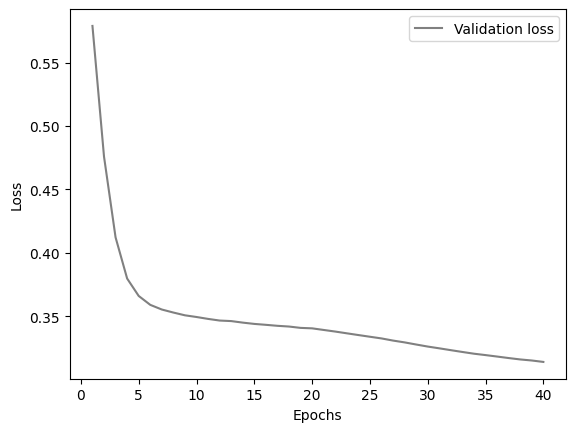

In [63]:
# Plotting validation loss over the epochs
classifier_val_loss = classifier_history.history['val_loss']
epochs = range(1, len(classifier_val_loss) + 1)
plt.plot(epochs, classifier_val_loss, color = 'grey', label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [64]:
# Predictions